In [40]:
#ensure that print and division functions work correctly under python 2.X
from __future__ import print_function, division 

#import numpy, scipy, math and astropy libraries
import numpy as np
import scipy as sp
import math
import astropy

#import the interpolate command
from scipy.interpolate import interp1d

#import matplotlib so that we can make plots; import common subroutines and give them compact names
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#kludgy way to import EqW measurement routines that were built off Elisabeth Newton's code 
#(from https://github.com/ernewton/ernlib/blob/master/eqwidth.py))
%run 'helpers.py'

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

In [41]:
#Read in AA Tau's 2008 spectrum, starting with the IR channel
IRSpec_2008 = np.genfromtxt('spectra/AATau_IR2008.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
IRSpec_2008.shape
IRSpec_2008_wavelength = IRSpec_2008[:,0]
IRSpec_2008_flux = IRSpec_2008[:,1]

#Now read in AA Tau's 2008 optical spectrum
OptSpec_2008 = np.genfromtxt('spectra/AATau_opt2008.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
OptSpec_2008.shape
OptSpec_2008_wavelength = OptSpec_2008[:,0]
OptSpec_2008_flux = OptSpec_2008[:,1]

In [42]:
#Read in AA Tau's 2014 spectra, starting with the IR channel
IRSpec_dec2_2014 = np.genfromtxt('spectra/AATau_IR2014dec02.spec', usecols=range(2), filling_values = -99.)
IRSpec_dec12_2014 = np.genfromtxt('spectra/AATau_IR2014dec12_corrected.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
IRSpec_dec2_2014.shape
IRSpec_dec2_2014_wavelength = IRSpec_dec2_2014[:,0]
IRSpec_dec2_2014_flux = IRSpec_dec2_2014[:,1]

IRSpec_dec12_2014.shape
IRSpec_dec12_2014_wavelength = IRSpec_dec12_2014[:,0]
IRSpec_dec12_2014_flux = IRSpec_dec12_2014[:,1]

#Now read in AA Tau's 2014 optical spectra
OptSpec_dec2_2014 = np.genfromtxt('spectra/AATau_opt2014dec02.spec', usecols=range(2), filling_values = -99.)
OptSpec_dec12_2014 = np.genfromtxt('spectra/AATau_opt2014dec12.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
OptSpec_dec2_2014.shape
OptSpec_dec2_2014_wavelength = OptSpec_dec2_2014[:,0]
OptSpec_dec2_2014_flux = OptSpec_dec2_2014[:,1]

OptSpec_dec12_2014.shape
OptSpec_dec12_2014_wavelength = OptSpec_dec12_2014[:,0]
OptSpec_dec12_2014_flux = OptSpec_dec12_2014[:,1]

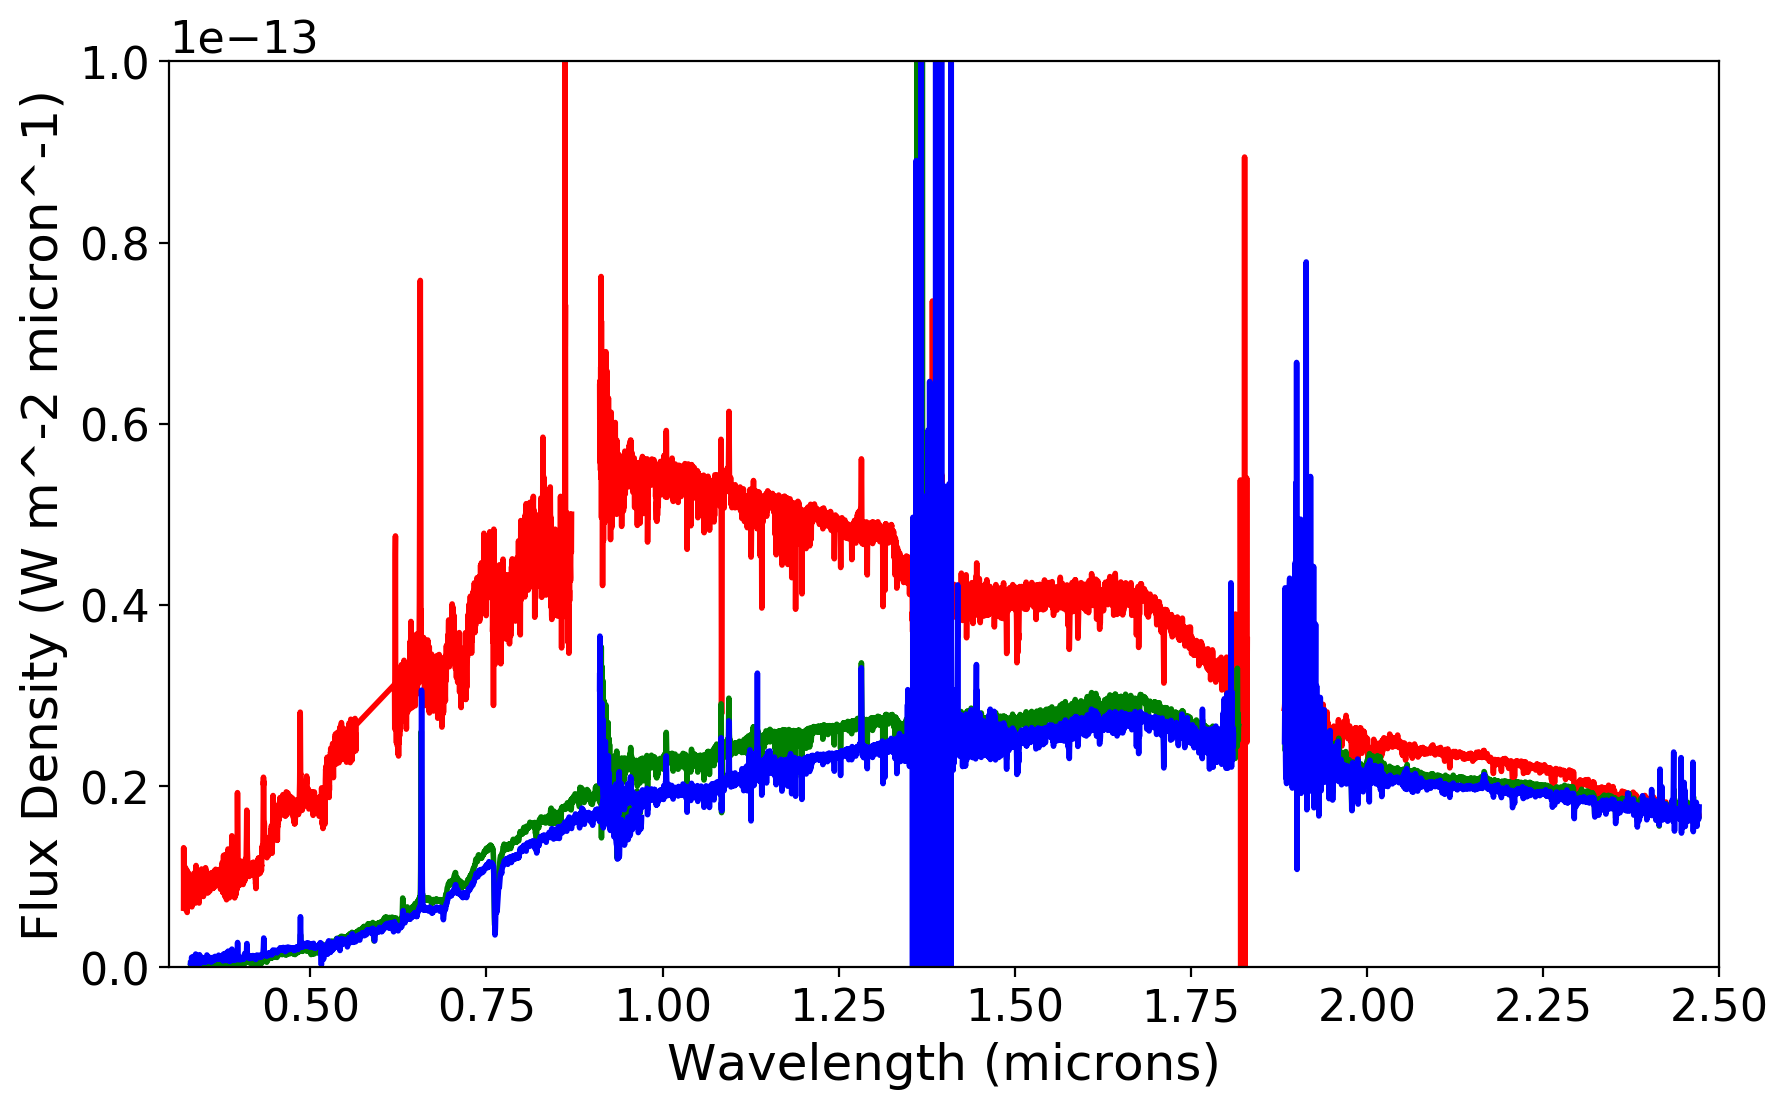

In [60]:
#now plot all the spectra 
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 2, color = 'red')

plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 2, color = 'green')

plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 2, color = 'blue')


#And now compute and overlay the blackbody curve
#scaled_solarlike_blackbody = planckMicron(wavelength_microns[:],5770)/(1.5E10)

#plt.plot(wavelength_microns[:],scaled_solarlike_blackbody,linewidth = 4, color = 'y')
plt.axis([0.3,2.5,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

Interesting.  Note that the two december 2014 IR spectra are **exactly** the same, such that there are no differences at all revealed by the diff command.  I think this means there must be a transcription error somewhere along the way; sort this out with Kristen when she returns!

2008 Ha:  -0.00203733272388
Dec 2 2014 Ha:  -0.00327864354385
Dec 12 2014 Ha:  -0.00511278460152


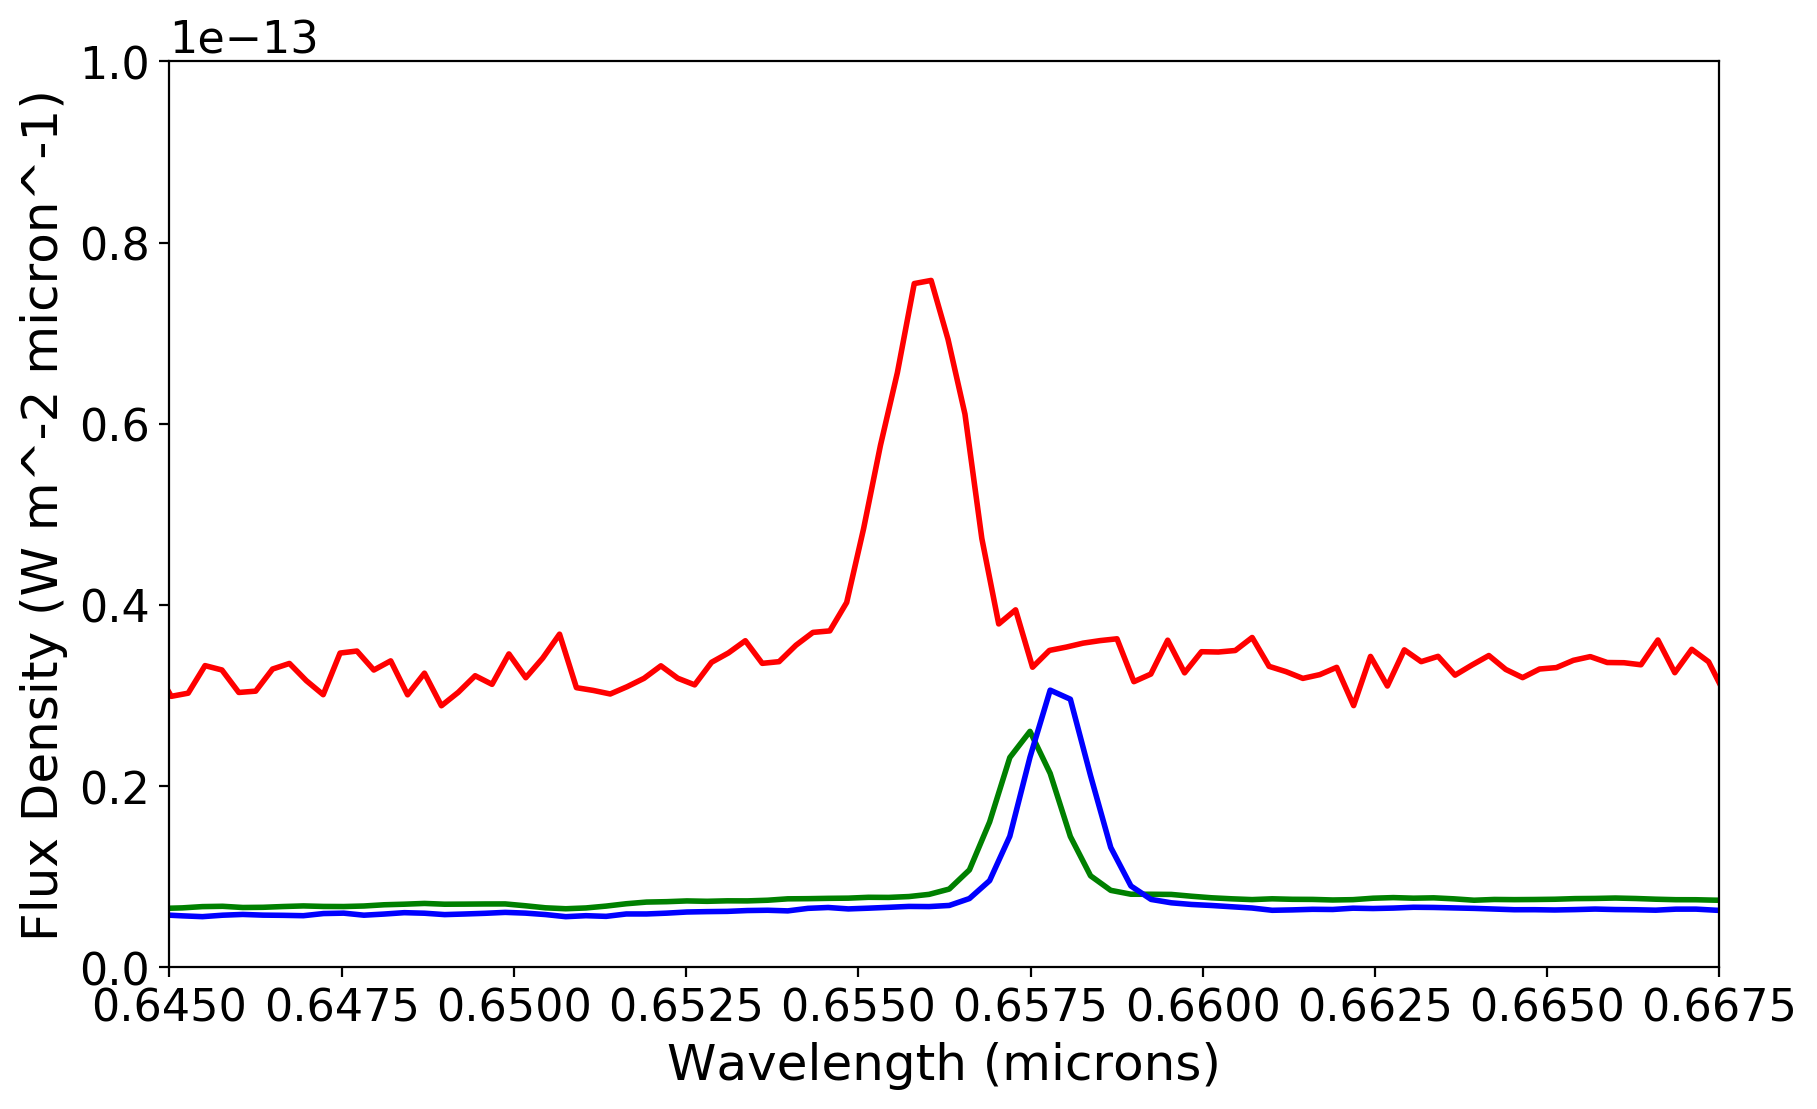

In [44]:
#Now zoom in on Halpha and compute the EqW.
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.axis([0.645,0.6675,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

HaEqW_2008 = measure_eqw(OptSpec_2008_wavelength, OptSpec_2008_flux, 0.654, 0.6575, 0.645, 0.65, 
                         0.66, 0.665, trapsum=False)
print('2008 Ha: ', HaEqW_2008)

HaEqW_dec2_2014 = measure_eqw(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, 0.655, 0.66, 0.645, 0.65, 
                         0.6625, 0.6675, trapsum=False)
print('Dec 2 2014 Ha: ', HaEqW_dec2_2014)

HaEqW_dec12_2014 = measure_eqw(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, 0.656, 0.66, 0.645, 0.65, 
                         0.6625, 0.6675, trapsum=False)
print('Dec 12 2014 Ha: ', HaEqW_dec12_2014)

2008 Hbeta:  -0.000544323821138
Dec 2 2014 Hbeta:  -0.000914421710071
Dec 12 2014 Hbeta:  -0.00130033765273


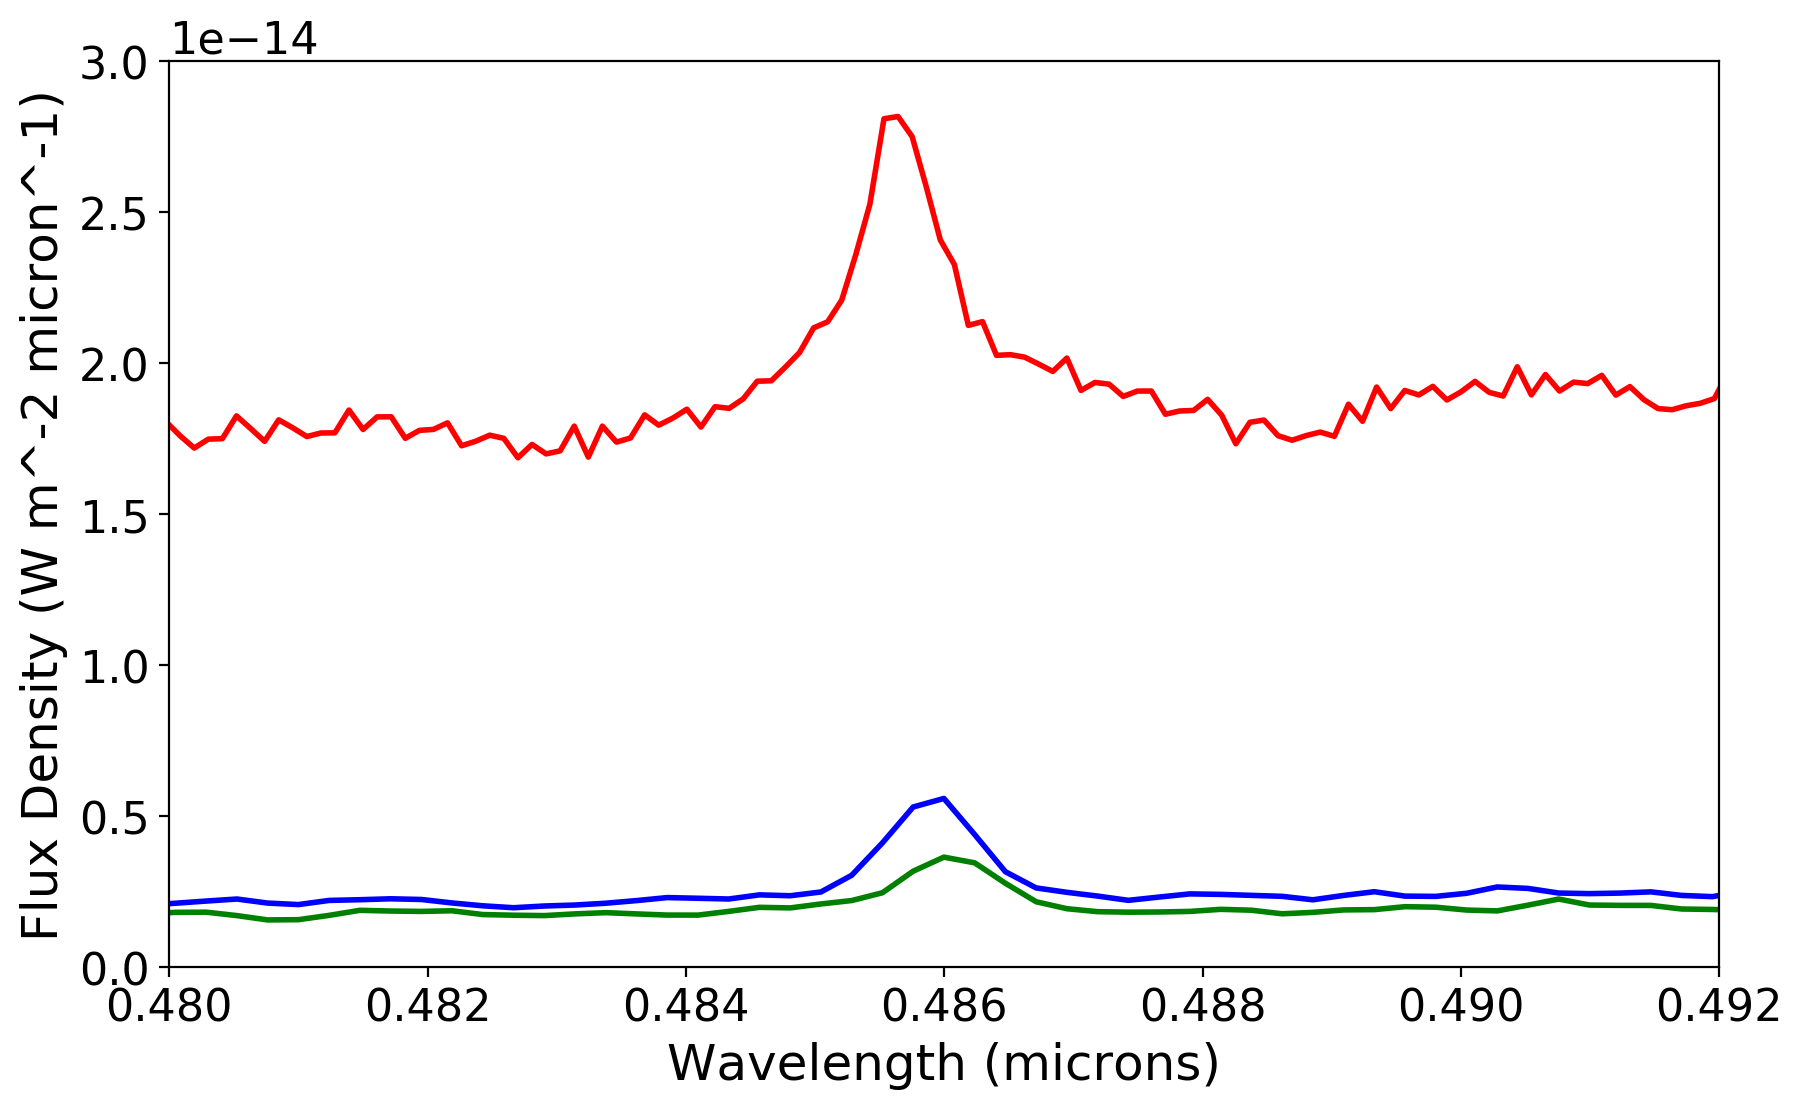

In [45]:
#Now zoom in on Hbeta and compute the EqW.
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.axis([0.48,0.492,0,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

HbetaEqW_2008 = measure_eqw(OptSpec_2008_wavelength, OptSpec_2008_flux, 0.4845, 0.487, 0.48, 0.483, 
                         0.489, 0.492, trapsum=False)
print('2008 Hbeta: ', HbetaEqW_2008)

HbetaEqW_dec2_2014 = measure_eqw(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, 0.4845, 0.487, 0.48, 0.483, 
                         0.489, 0.492, trapsum=False)
print('Dec 2 2014 Hbeta: ', HbetaEqW_dec2_2014)

HbetaEqW_dec12_2014 = measure_eqw(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, 0.4845, 0.487, 0.48, 0.483, 
                         0.489, 0.492, trapsum=False)
print('Dec 12 2014 Hbeta: ', HbetaEqW_dec12_2014)

2008 PaDelta:  -9.6471922425e-05


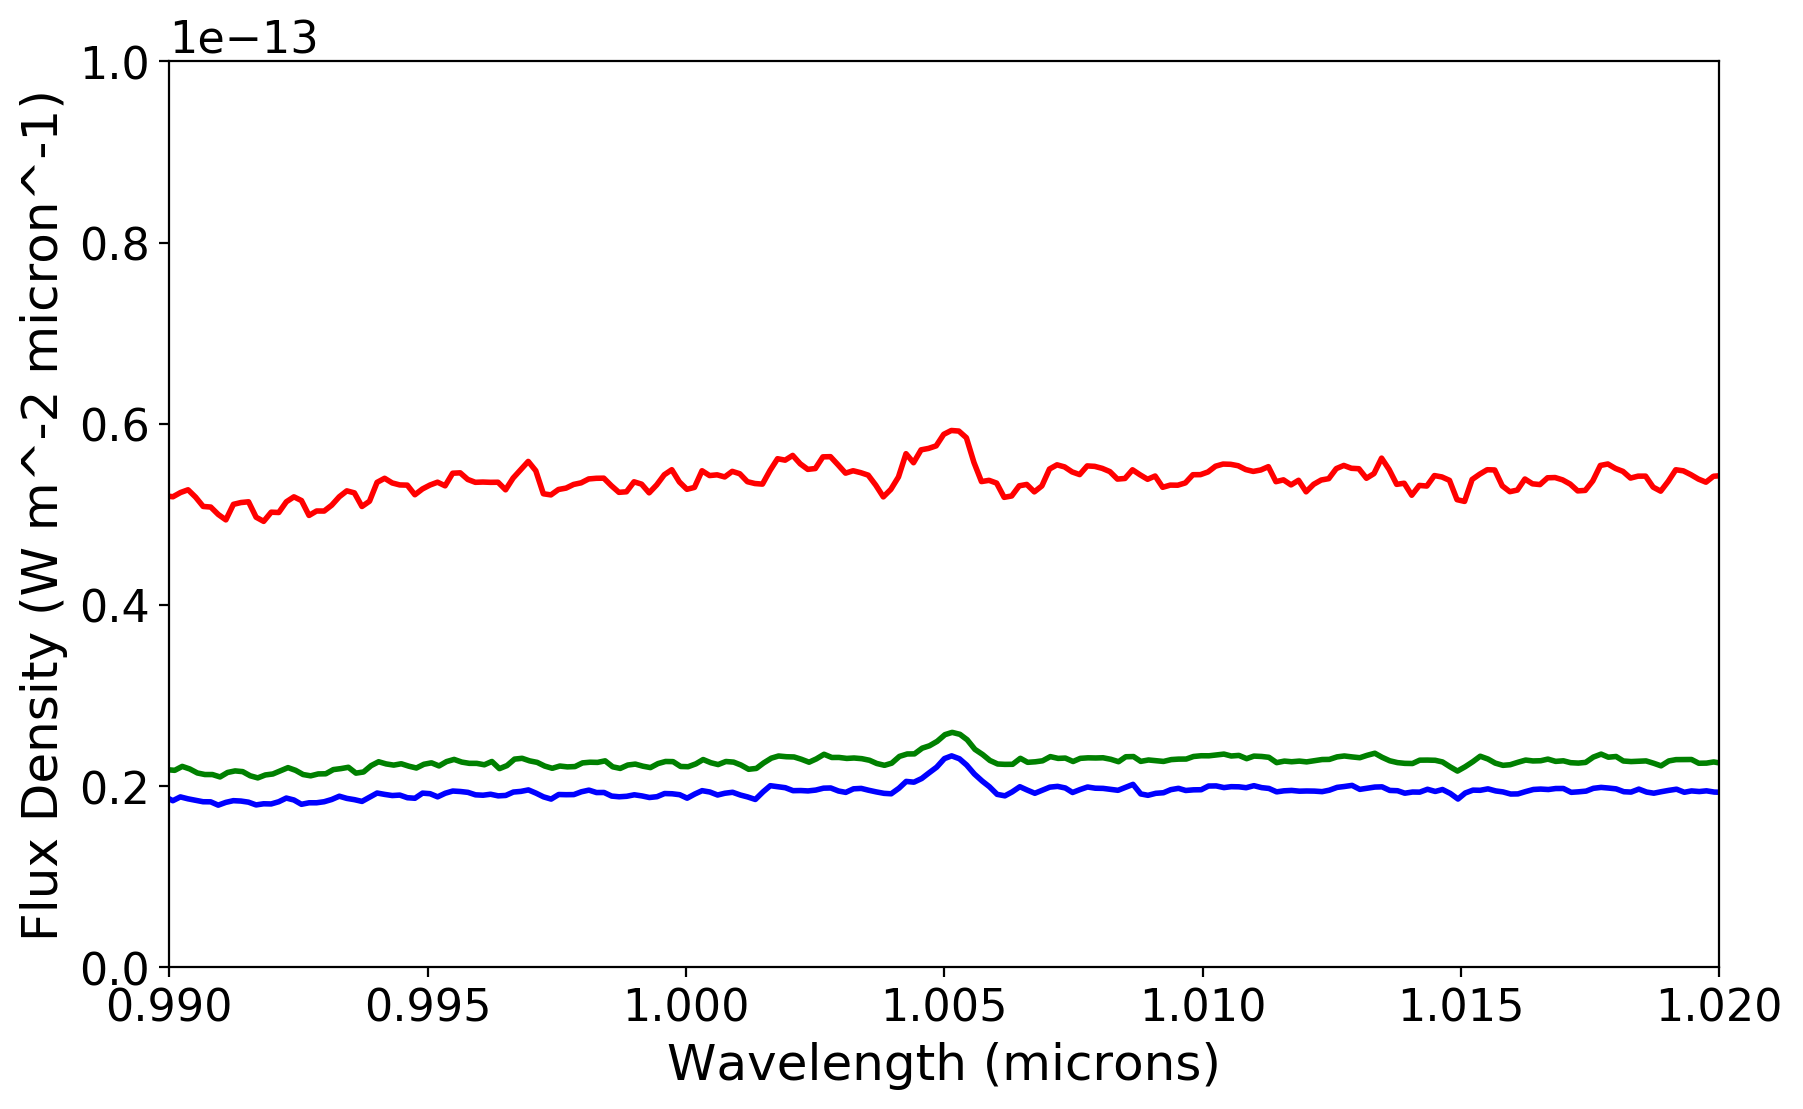

In [53]:
#Now zoom in on PaDelta and compute the EqW.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')
#originally I could only see two spectra in this plot, so add an offset to the dec 2nd to show
#that it is exactly the same as the dec12...
#plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux+1e-14, linewidth = 2, color = 'orange')

plt.axis([0.99,1.02,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

#WHY IS THIS EQUIVALENT WIDTH MEASUREMENT NOT WORKING?!?!?!?!
PaDelta_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 1.004, 1.006, 0.999, 1.001, 
                         1.008, 1.01, trapsum=True)
print('2008 PaDelta: ', PaDelta_EqW_2008)

#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

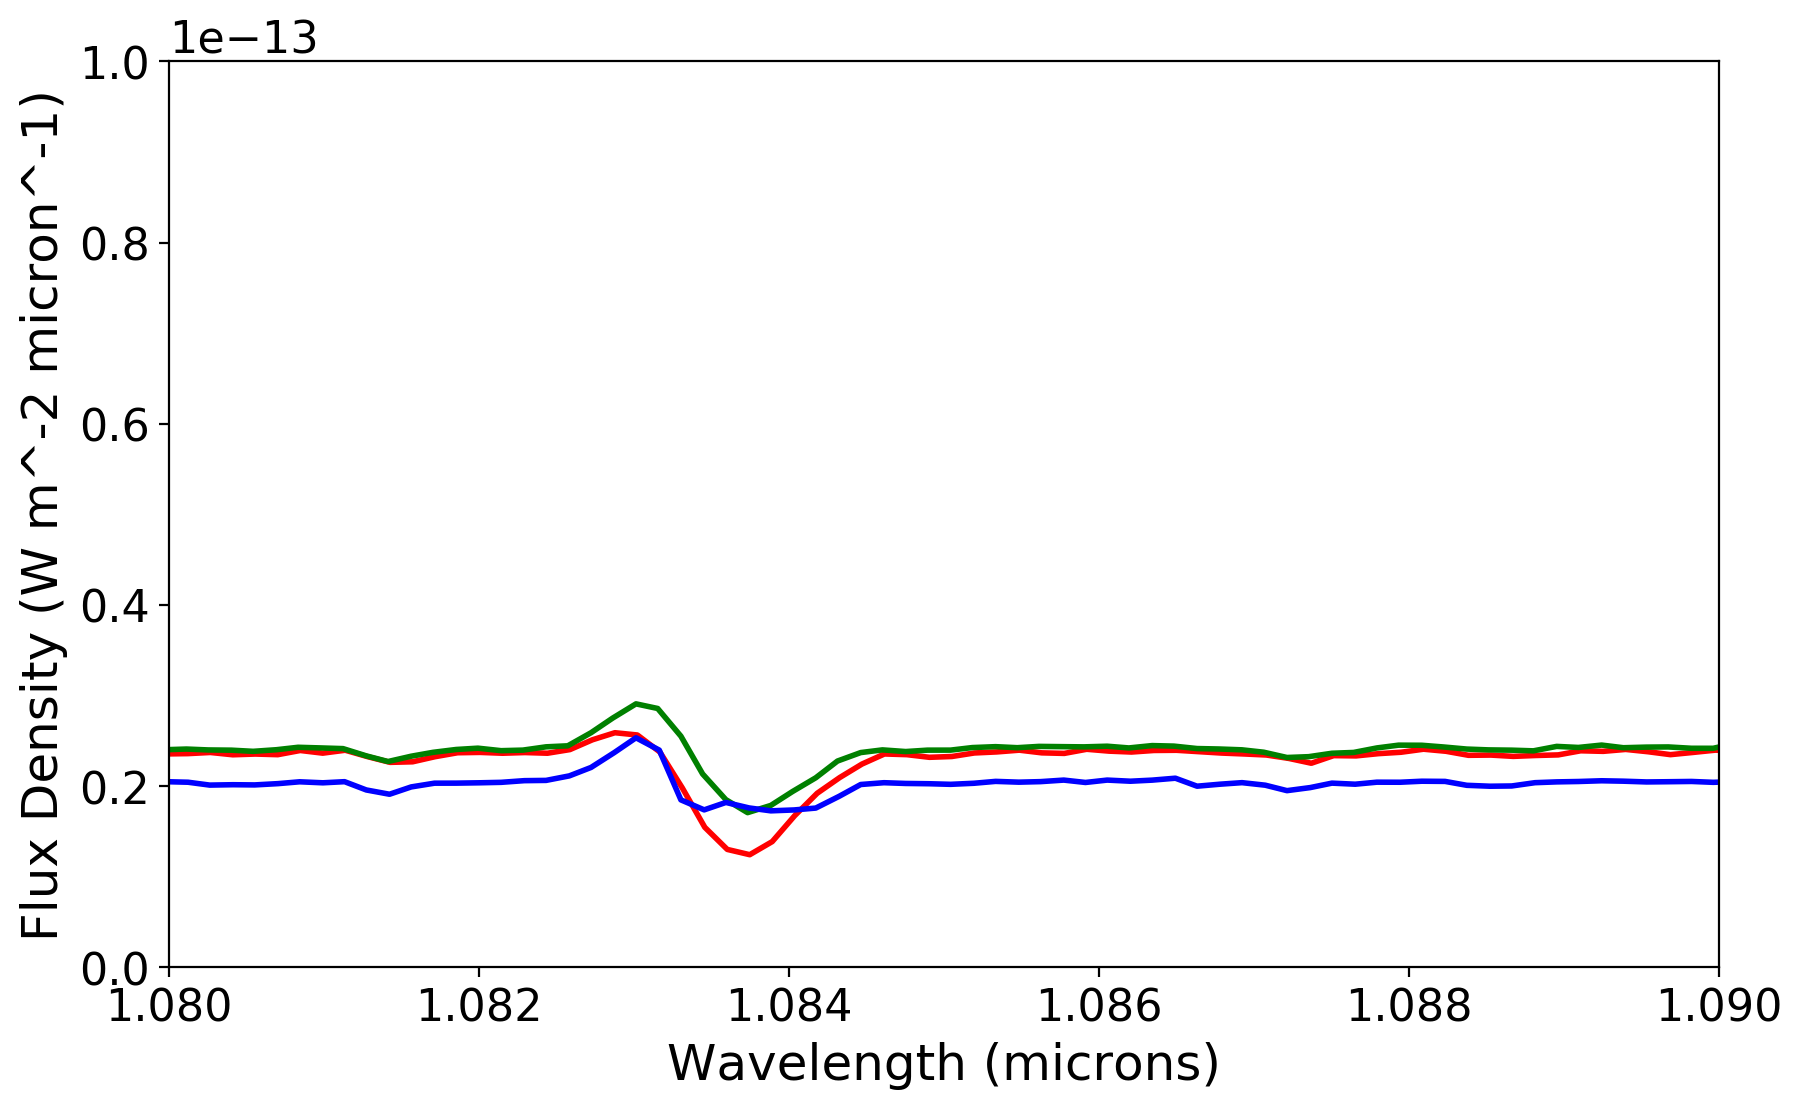

In [64]:
#Now zoom in on HeI 10830 and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2.25, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')


plt.axis([1.08,1.09,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

#PaDelta_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=True)
#print('2008 PaDelta: ', PaDelta_EqW_2008)

#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

2008 PaBeta:  -0.000116504213235
Dec. 2 2014 PaBeta:  -0.000206668509586
Dec. 12 2014 PaBeta:  -0.000340870981568


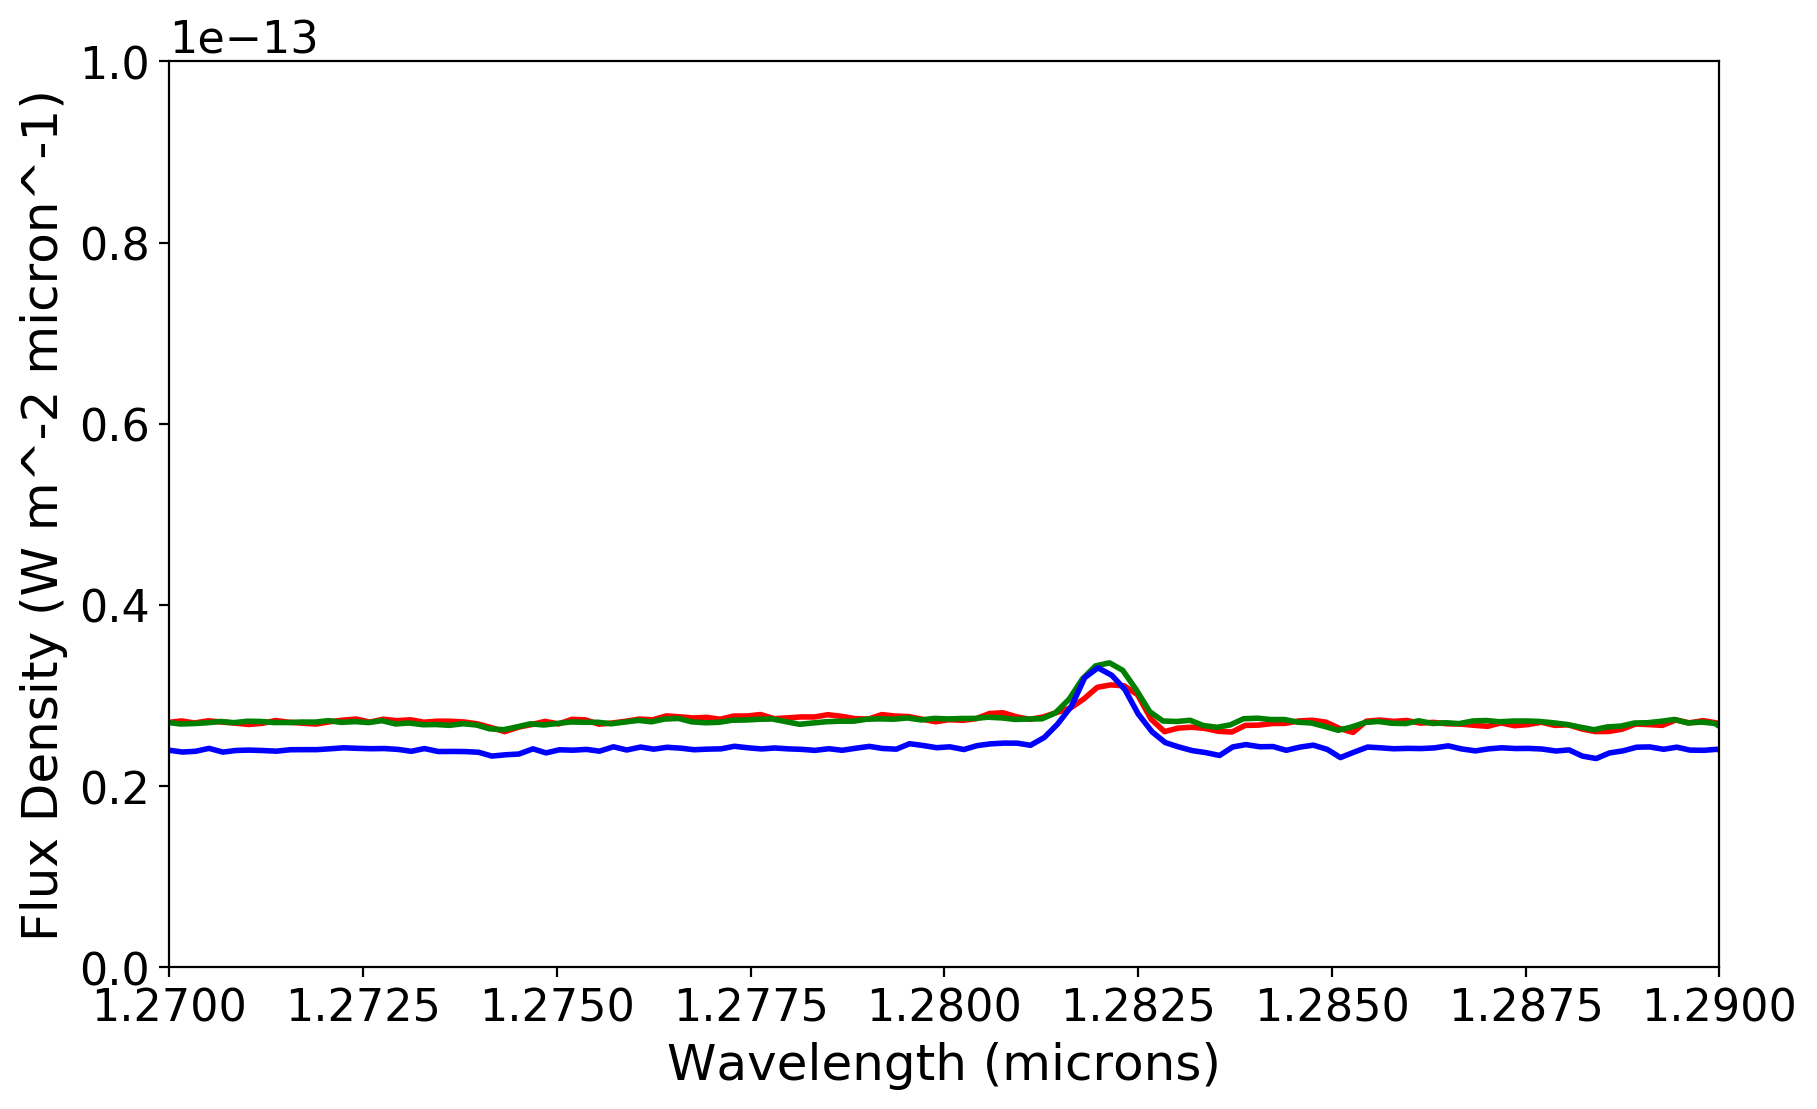

In [63]:
#Now zoom in on Paschen beta and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.8, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')


plt.axis([1.27,1.29,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

PaBeta_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 1.281, 1.2835, 1.275, 1.2775, 
                         1.286, 1.2885, trapsum=True)
print('2008 PaBeta: ', PaBeta_EqW_2008)

PaBeta_EqW_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.281, 1.2835, 1.275, 1.2775, 
                         1.286, 1.2885, trapsum=True)
print('Dec. 2 2014 PaBeta: ', PaBeta_EqW_dec2_2014)


PaBeta_EqW_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.281, 1.2835, 1.275, 1.2775, 
                         1.286, 1.2885, trapsum=True)
print('Dec. 12 2014 PaBeta: ', PaBeta_EqW_dec12_2014)


#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

2008 BrGamma:  -5.50182258382e-05
Dec. 2 2014 BrGamma:  3.21843316309e-05
Dec. 12 2014 BrGamma:  0.00010552721174


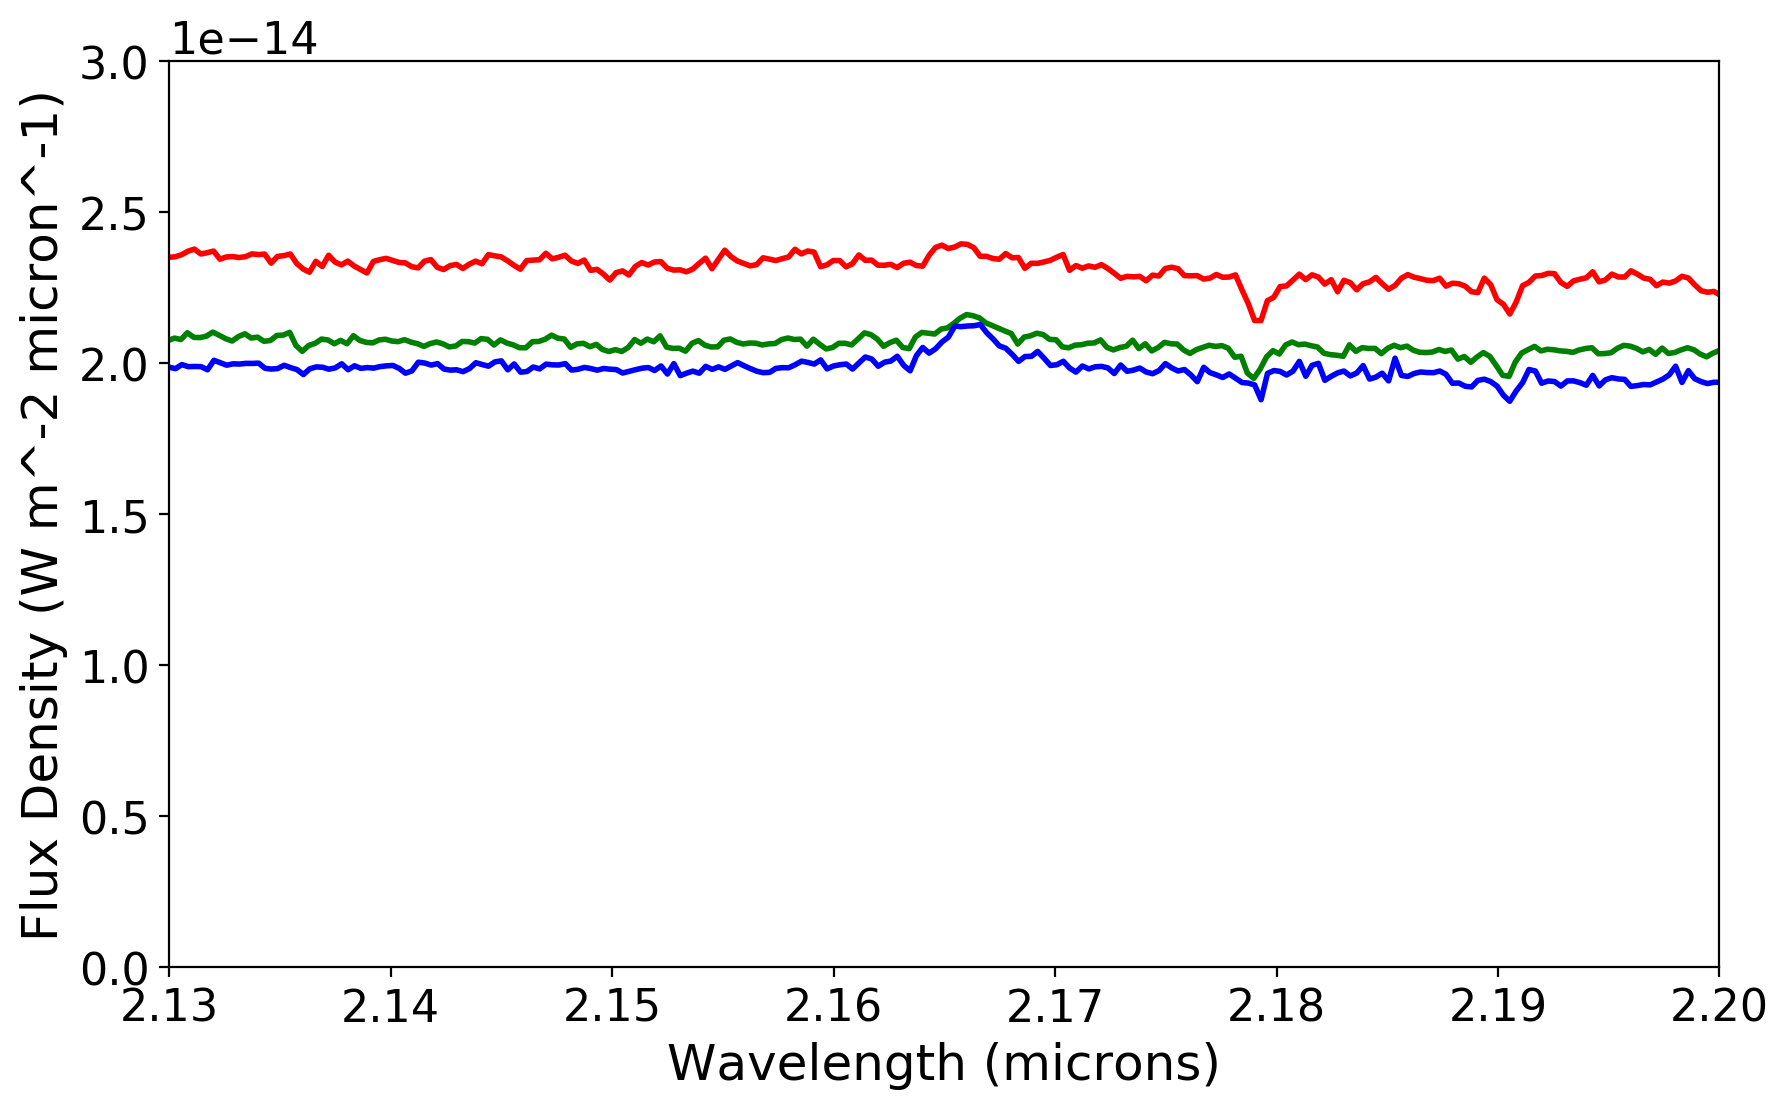

In [62]:
#Now zoom in on Brackett gamma and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')


plt.axis([2.13,2.2,0,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

BrGamma_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 2.15, 2.1575, 2.1625, 2.17, 
                         2.1725, 2.18, trapsum=True)
print('2008 BrGamma: ', BrGamma_EqW_2008)

BrGamma_EqW_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 2.15, 2.1575, 2.1625, 2.17, 
                         2.1725, 2.18, trapsum=True)
print('Dec. 2 2014 BrGamma: ', BrGamma_EqW_dec2_2014)


BrGamma_EqW_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 2.15, 2.1575, 2.1625, 2.17, 
                         2.1725, 2.18, trapsum=True)
print('Dec. 12 2014 BrGamma: ', BrGamma_EqW_dec12_2014)


#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

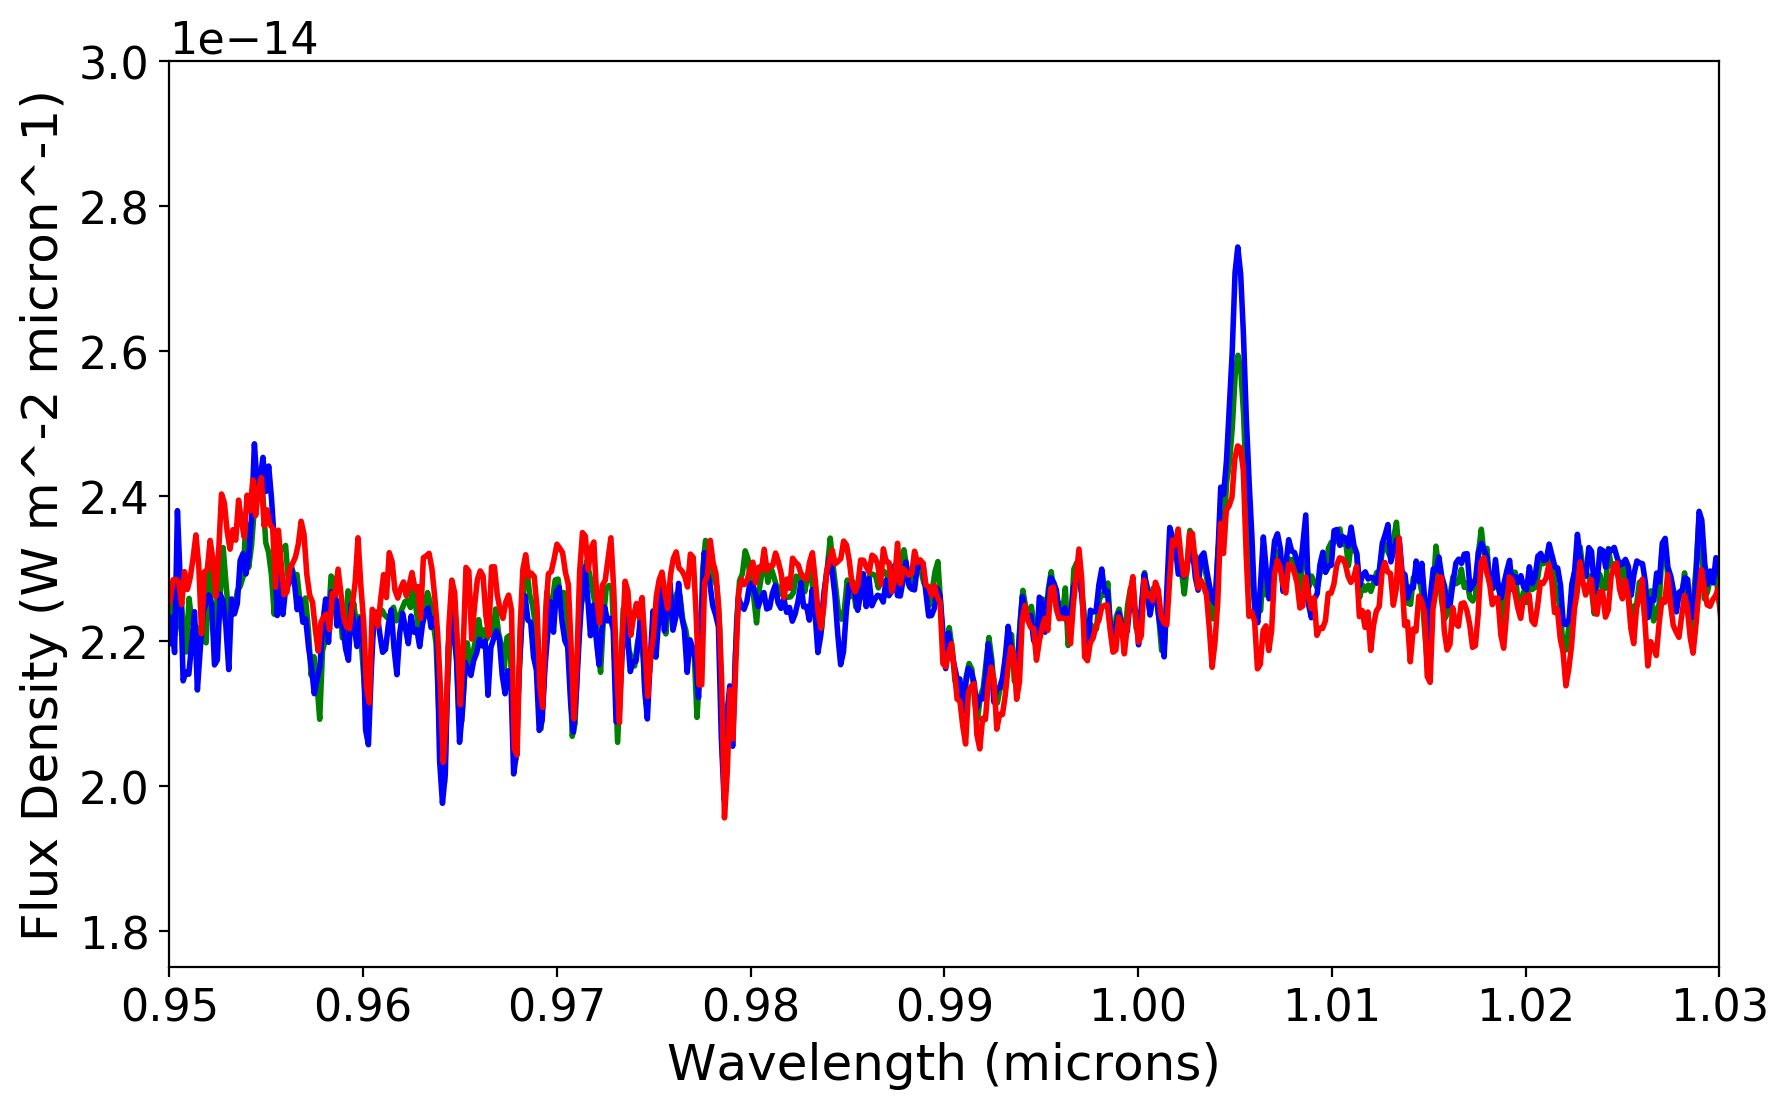

In [102]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.175, linewidth = 2, color = 'blue')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2.4, linewidth = 2, color = 'red')

plt.axis([0.95,1.03,1.75E-14,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

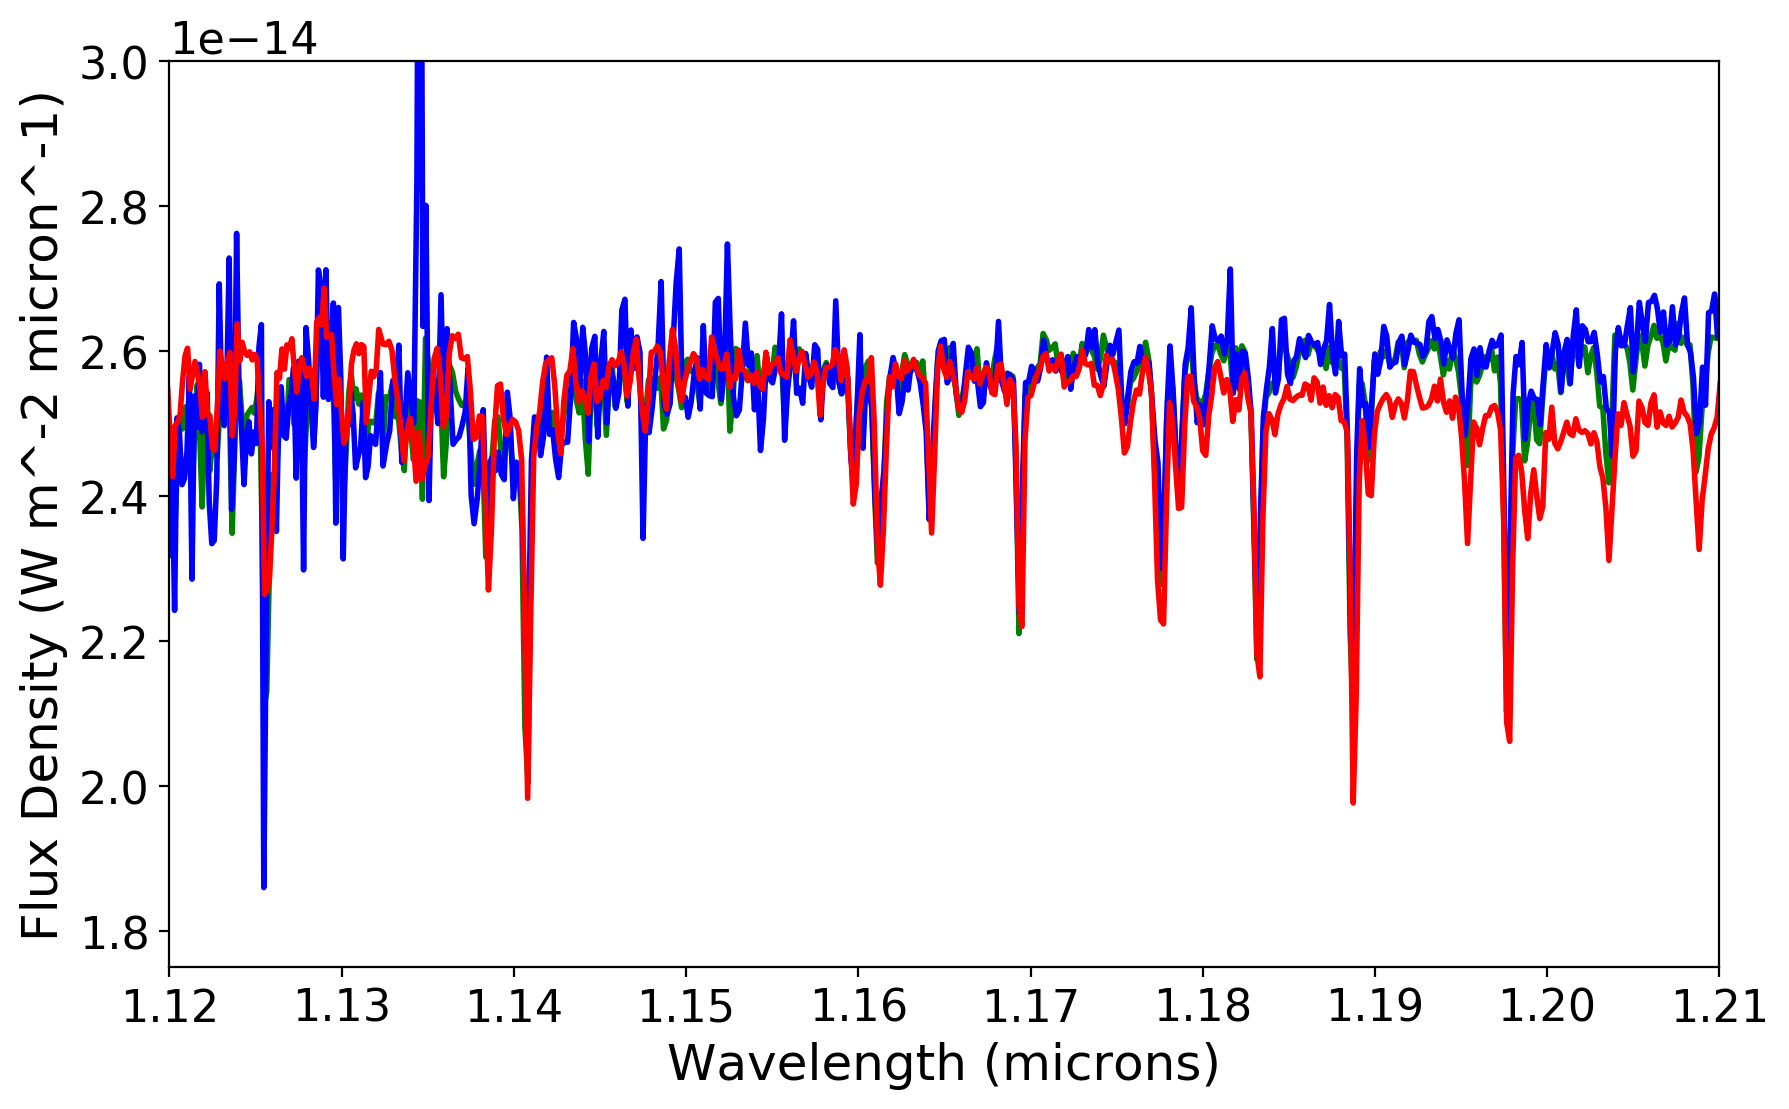

In [96]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.15, linewidth = 2, color = 'blue')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2, linewidth = 2, color = 'red')


plt.axis([1.12,1.21,1.75E-14,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

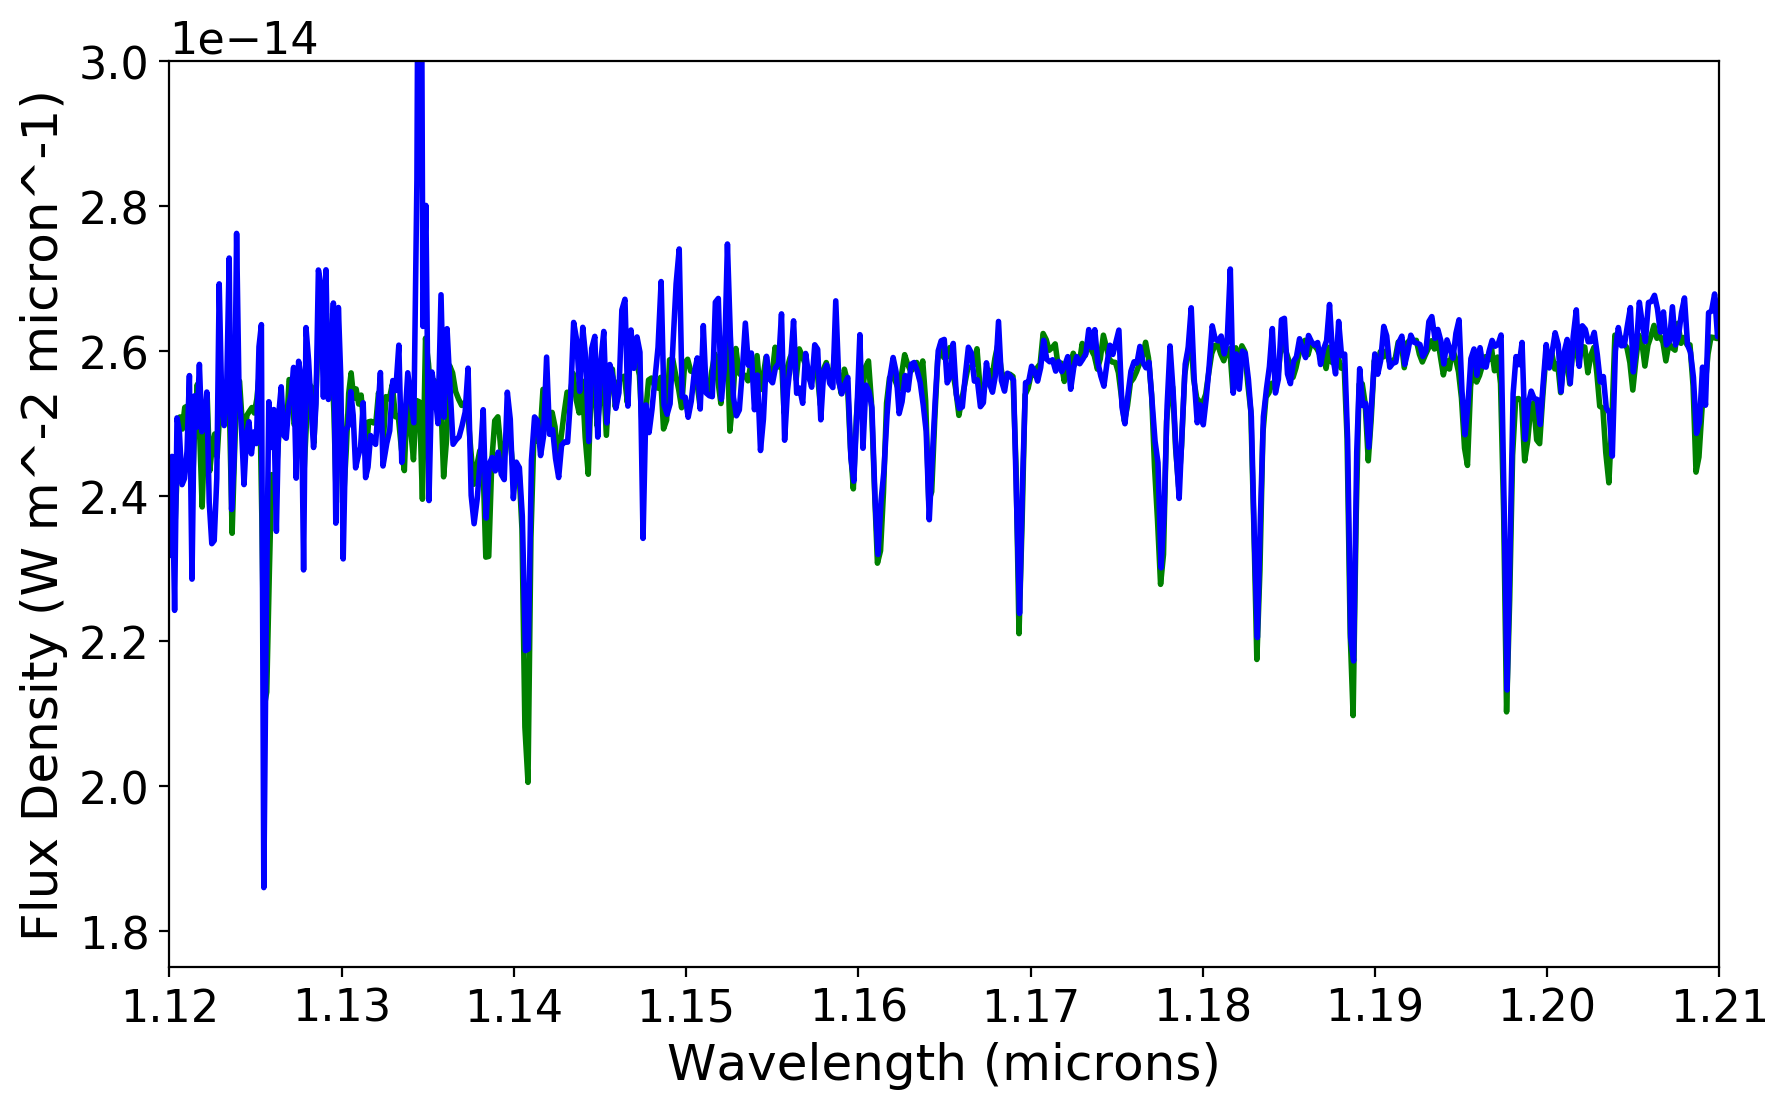

In [93]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
#plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.5, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.15, linewidth = 2, color = 'blue')

plt.axis([1.12,1.21,1.75E-14,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

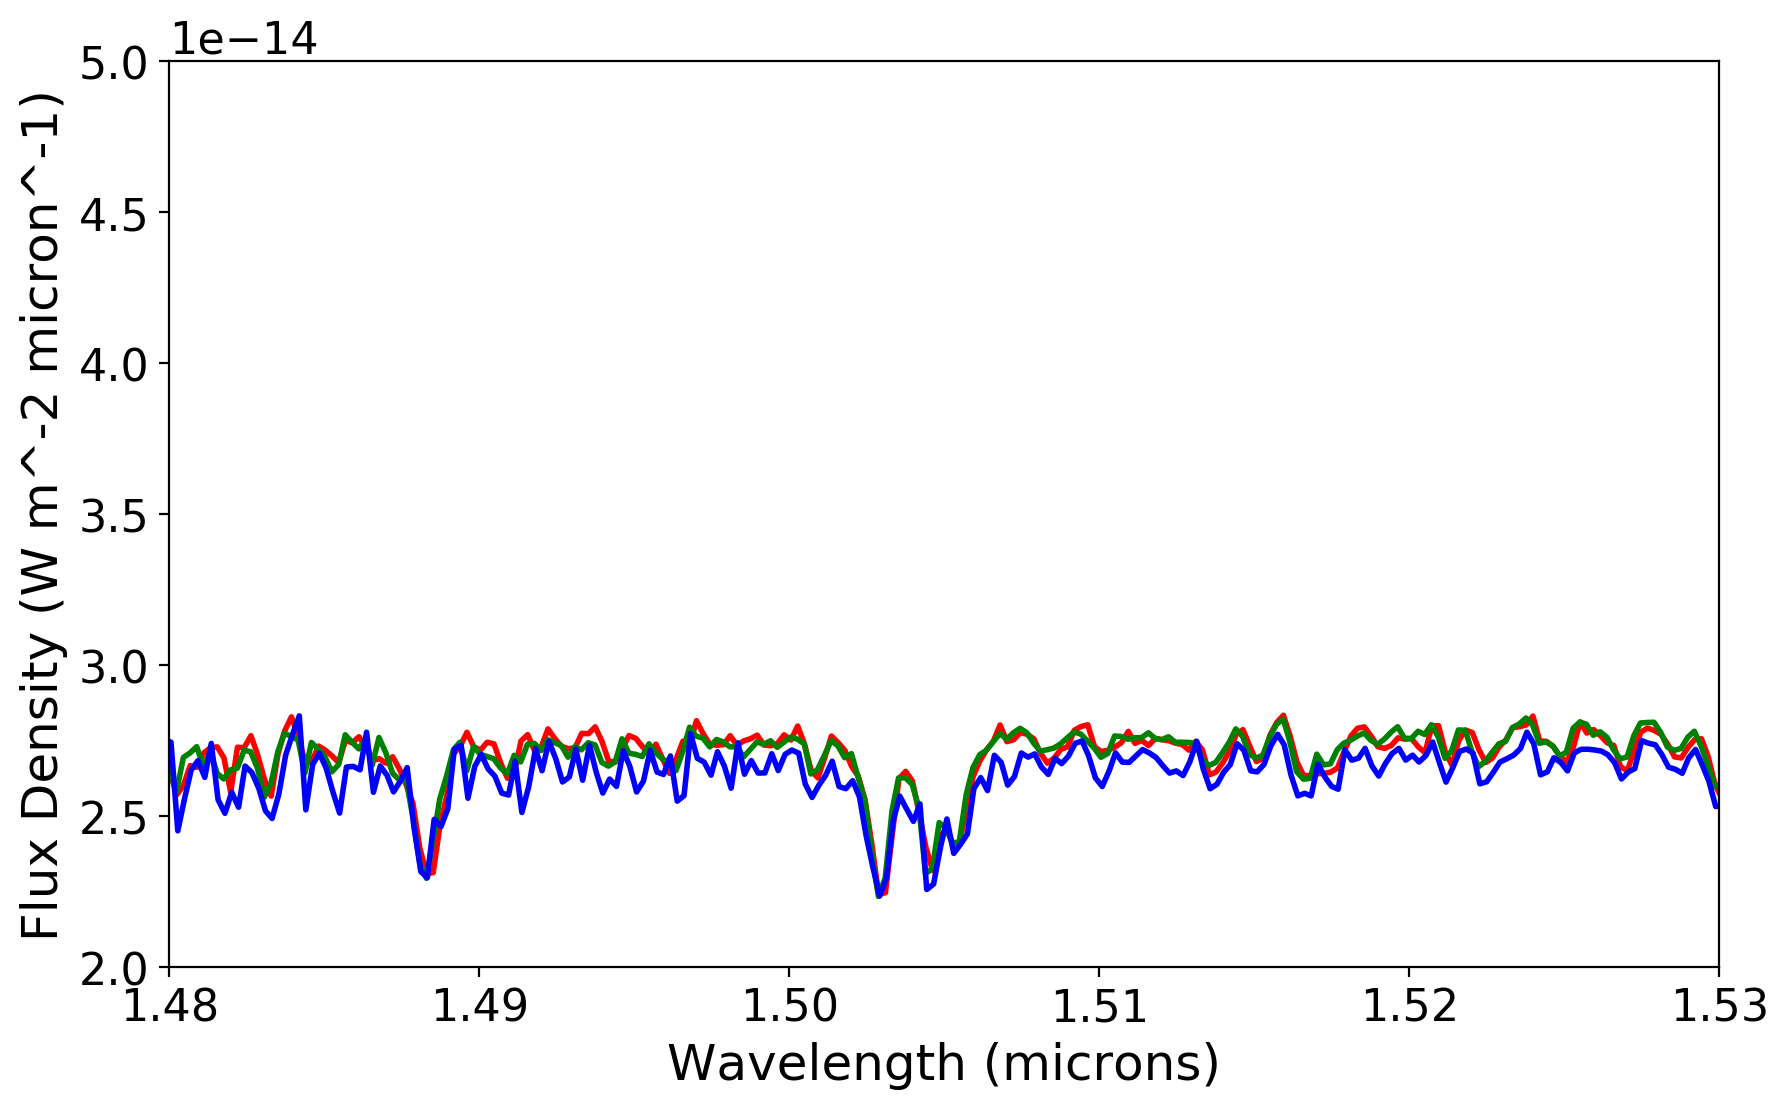

In [85]:
#Now zoom in on the ~1.5 micron K and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.5, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.05, linewidth = 2, color = 'blue')

plt.axis([1.48,1.53,2E-14,5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

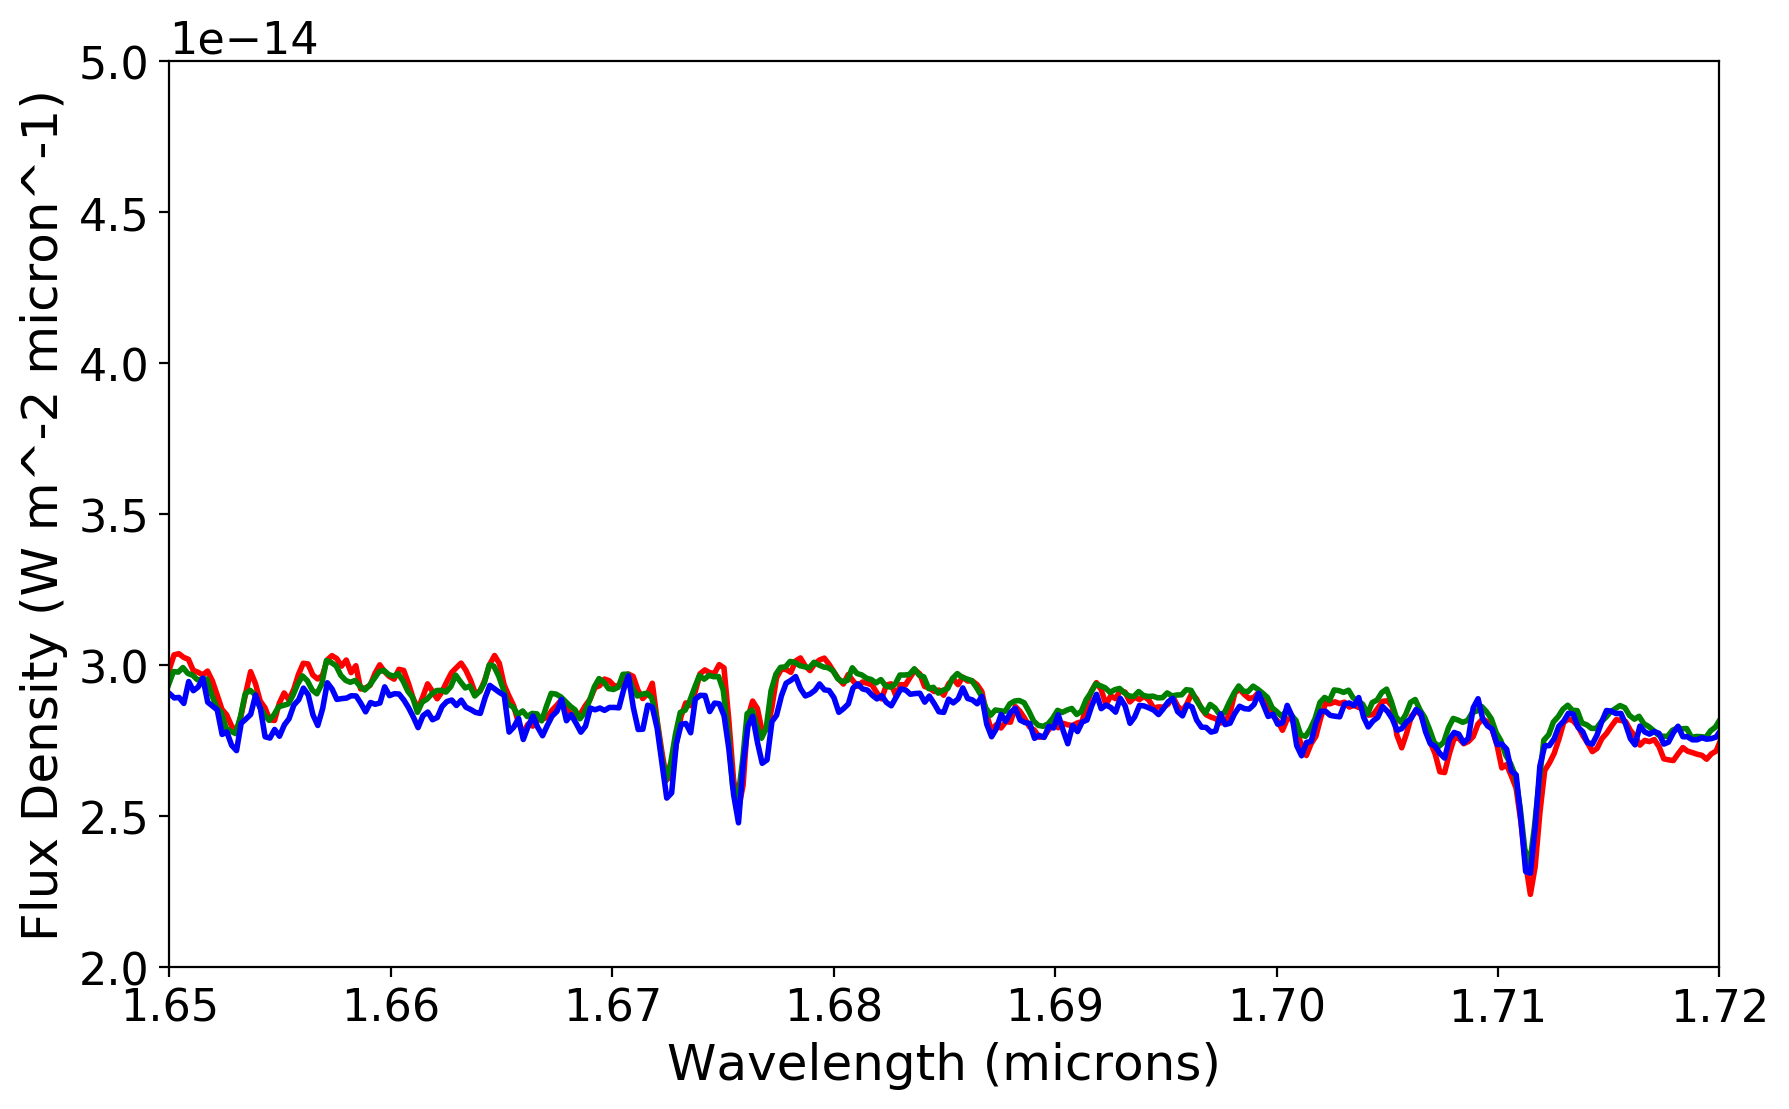

In [82]:
#Now zoom in on the ~1.7 micron Al and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.4, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.05, linewidth = 2, color = 'blue')

plt.axis([1.65,1.72,2E-14,5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

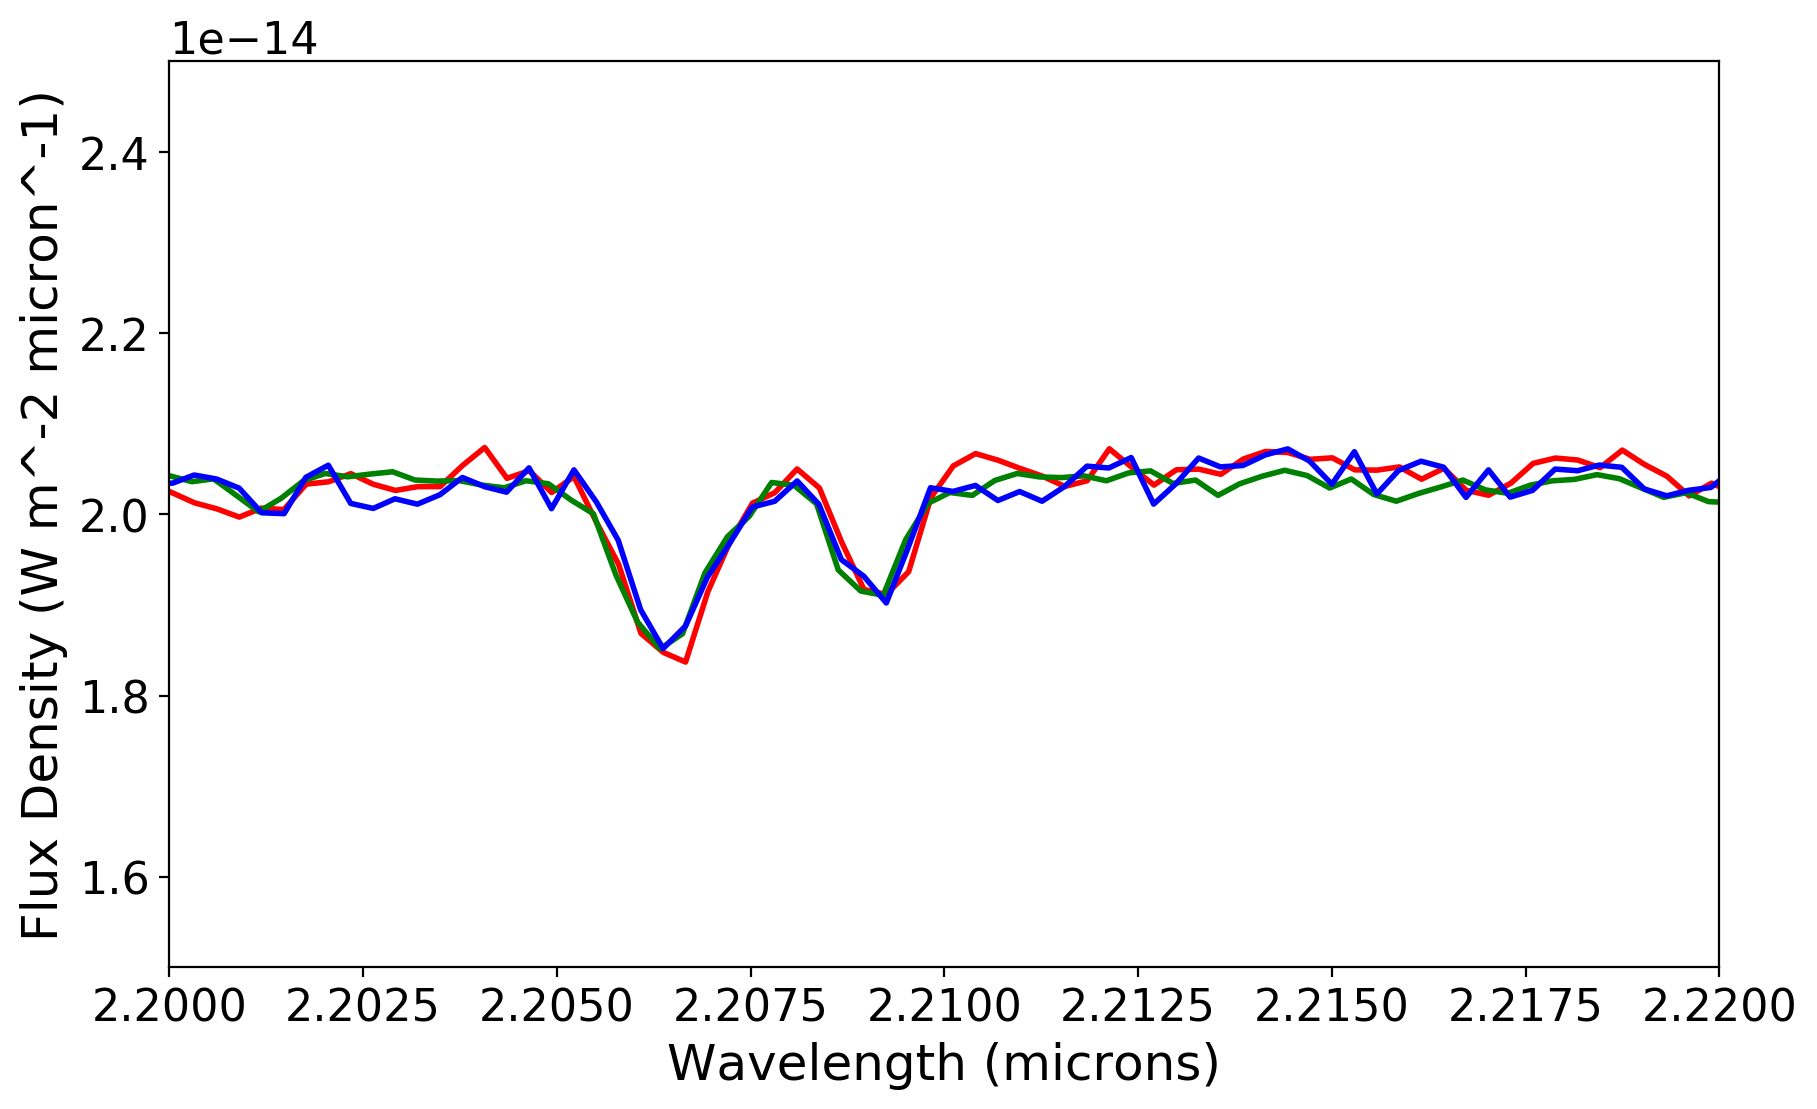

In [78]:
#Now zoom in on the 2.2 micron sodium doublet and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.1, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.05, linewidth = 2, color = 'blue')

plt.axis([2.2,2.22,1.5E-14,2.5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

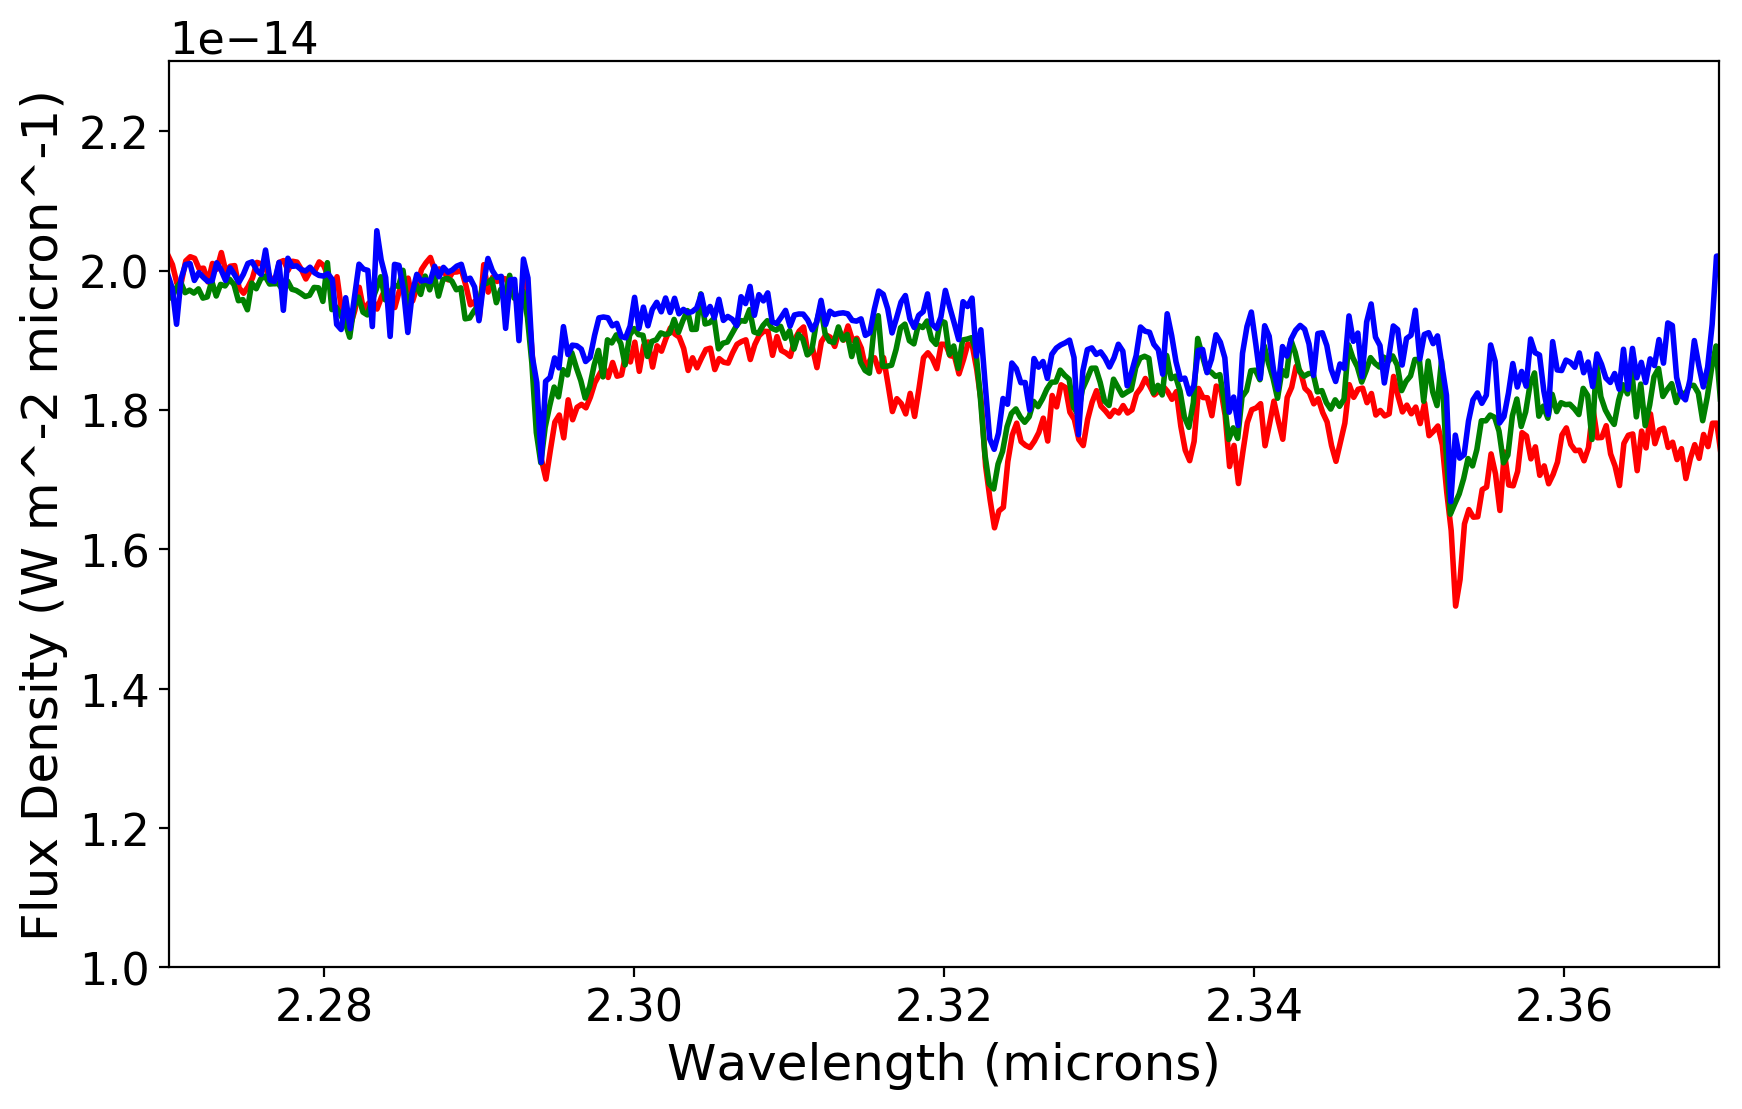

In [77]:
#Now zoom in on the 2.3 micron CO bandheads and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.08, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.05, linewidth = 2, color = 'blue')

plt.axis([2.27,2.37,1E-14,2.3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????